## Importing Libraries and Modules

The initial step involves importing all necessary libraries and modules required for the project. Here's a detailed explanation of each import and its purpose:

---

### Why These Libraries?
The combination of these libraries provides a powerful toolkit for handling:
1. **Data Processing**: OpenCV, skimage, and NumPy for loading, resizing, and normalizing satellite images.
2. **Visualization**: Matplotlib for displaying images and tracking model performance.
3. **Deep Learning**: TensorFlow/Keras for building and training the U-Net model with robust optimization and callbacks.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Downloading the Dataset Using KaggleHub

### **Outcome**:
After running this step:
- The dataset is successfully downloaded to a local directory.
- Its path is printed for reference in the next steps (e.g., loading images and masks).


In [ ]:
# Download the dataset using KaggleHub
import kagglehub
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")
print("Path to dataset files:", path)


100%|██████████| 247M/247M [00:02<00:00, 86.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2


## Loading Satellite Images and Masks


### **Purpose**:
This step organizes the dataset by separating the satellite images and their corresponding masks into two lists for subsequent processing.

---

### **Why This Step is Important**:
- **Data Organization**: Clearly separates images and their respective masks for further processing.
- **File Matching**: Ensures a one-to-one correspondence between inputs (images) and labels (masks).

---

### **Outcome**:
After running this step:
1. Two lists, `image_files` and `mask_files`, are created.
2. These lists contain paths to all satellite images and their corresponding masks.



In [ ]:
from PIL import Image

def load_images_and_masks(dataset_path):
    """
    Loads the satellite images and masks from the dataset path.

    Args:
        dataset_path (str): Path to the dataset root directory.

    Returns:
        image_files (list): List of paths to satellite images.
        mask_files (list): List of paths to corresponding masks.
    """
    images_dir = os.path.join(dataset_path, "Water Bodies Dataset/Images")
    masks_dir = os.path.join(dataset_path, "Water Bodies Dataset/Masks")

    # Load all image and mask files
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.jpg', '.tif'))])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(('.jpg', '.tif'))])

    return image_files, mask_files

# Example usage
dataset_path = "/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2"
# Load images and masks
image_files, mask_files = load_images_and_masks(dataset_path)

## Visualizing Satellite Images and Masks

---

### **Purpose**:
This function visually pairs satellite images with their corresponding segmentation masks to ensure:
1. **Data Integrity**: Verifies that images and masks are correctly aligned.
2. **Data Understanding**: Helps in understanding the structure and characteristics of the dataset.

---

### **Why This Step is Important**:
1. **Ensures Data Quality**: Identifies potential issues like misaligned masks, corrupted files, or inconsistencies in the dataset.
2. **Visual Validation**: Provides insight into how well masks represent water bodies in satellite images.

---

### **Outcome**:
When this function is executed:
- A specified number of image-mask pairs are displayed side-by-side.
- Allows for manual verification of the dataset before moving to preprocessing and model training.


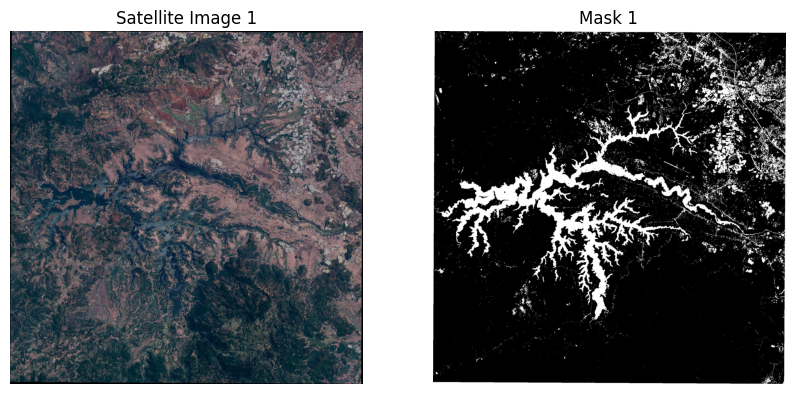

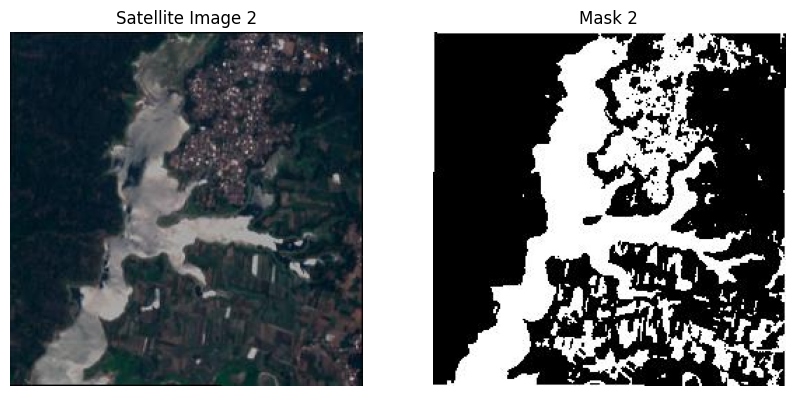

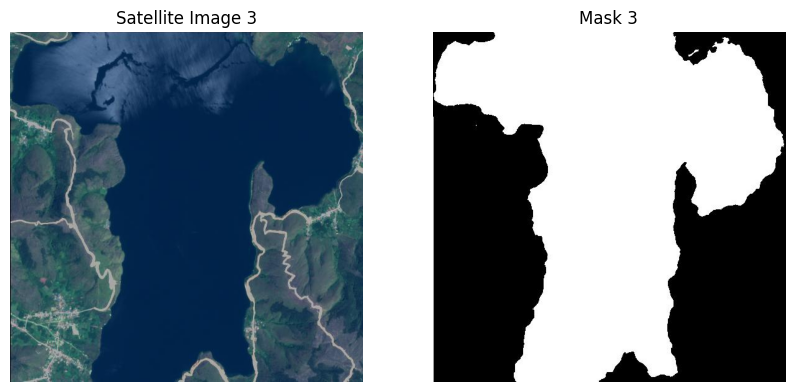

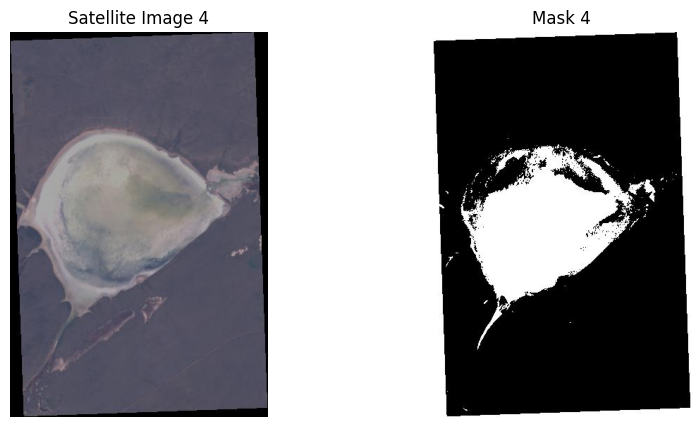

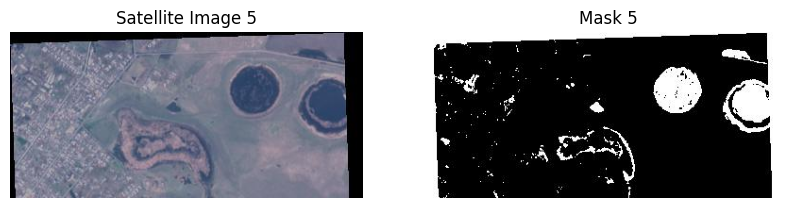

In [ ]:
def visualize_images_and_masks(image_files, mask_files, num_examples=5):
    """
    Visualizes satellite images and their corresponding masks.

    Args:
        image_files (list): List of file paths to satellite images.
        mask_files (list): List of file paths to corresponding masks.
        num_examples (int): Number of examples to display.
    """
    num_examples = min(num_examples, len(image_files), len(mask_files))

    for i in range(num_examples):
        # Load image and mask
        image = Image.open(image_files[i])
        mask = Image.open(mask_files[i])

        # Plot image and mask side by side
        plt.figure(figsize=(10, 5))

        # Display satellite image
        plt.subplot(1, 2, 1)
        plt.title(f"Satellite Image {i+1}")
        plt.imshow(image)
        plt.axis("off")

        # Display corresponding mask
        plt.subplot(1, 2, 2)
        plt.title(f"Mask {i+1}")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")

        plt.show()

# Visualize a few examples
visualize_images_and_masks(image_files, mask_files, num_examples=5)

## Resizing and Preparing Training Images

---

### **Purpose**:
This step processes the satellite images by resizing them to a fixed shape and preparing them for model training in a format that the model can efficiently use.

---

### **Why This Step is Important**:
1. **Prepares Images for Model Input**: Converts images into a consistent size and format required by the neural network.
2. **Improves Computational Efficiency**: Using NumPy arrays optimizes memory usage and speeds up subsequent computations.

---

### **Outcome**:
After running this code:
1. All satellite images are resized to 128x128 pixels.
2. The resized images are stored in `train_images_array` as a NumPy array, ready for preprocessing and model training.


In [ ]:
train_images_array = []

for image_path in image_files:  # Use image_files from Step 3
    # Read and resize the image
    img = cv2.resize(cv2.imread(image_path, cv2.IMREAD_UNCHANGED), (128, 128))
    train_images_array.append(img)

# Convert the list to a NumPy array
train_images_array = np.array(train_images_array, dtype=np.float32)


## Resizing and Preparing Mask Images

---

### **Purpose**:
This step processes the mask images by resizing them to a fixed shape and converting them into a numerical format suitable for training. Mask images are the ground truth annotations that label water bodies in satellite images.

---

### **Why This Step is Important**:
1. **Prepares Masks for Model Output**: Resizes masks to match the input image size, ensuring proper alignment during training.
2. **Simplifies Mask Processing**: Converting masks to grayscale and using integer values makes it easier to interpret water vs. non-water pixels.

---

### **Outcome**:
After running this code:
1. All mask images are resized to 128x128 pixels.
2. The resized masks are stored in `mask_images_array` as a NumPy array, ready for preprocessing and model training.


In [ ]:
mask_images_array = []

for mask_path in mask_files:  # Use mask_files from Step 3
    # Read the mask as grayscale and resize it
    msk = cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), (128, 128))
    mask_images_array.append(msk)

# Convert the list to a NumPy array
mask_images_array = np.array(mask_images_array, dtype=np.uint8)


## Checking the Length of the Training Images Array

---

### **Purpose**:
This line checks the number of training images stored in the `train_images_array`. It helps ensure that all images have been successfully processed and loaded into the array.

---

### **Why This Step is Important**:
1. **Verification**:
   - Confirms that all images from `image_files` have been successfully loaded and processed.
   - Helps identify any discrepancies or missing images before proceeding.

2. **Debugging**:
   - If the length is unexpectedly low, it could indicate issues such as:
     - Incorrect file paths.
     - Missing or corrupted image files.
     - Errors during resizing or loading.

---

### **Outcome**:
After running this code:
- The total number of training images is displayed.
- You can compare this number with the length of `image_files` to ensure consistency.

In [ ]:
len(train_images_array)

2841

## Checking the Length of the Mask Images Array

---

### **Code**:
```python
len(mask_images_array)
```

---

### **Purpose**:
This line checks the number of mask images stored in the `mask_images_array`. It ensures that all corresponding ground truth masks have been successfully processed and loaded into the array.

---

### **Explanation**:
1. **`mask_images_array`**:
   - This array contains all the resized mask images (binary segmentation maps) prepared in the previous step.
   - Each mask corresponds to a satellite image in `train_images_array`.

2. **Using `len()`**:
   - The `len()` function returns the number of elements in the array.
   - In this context, it outputs the total count of masks in `mask_images_array`.

---

### **Why This Step is Important**:
1. **Verification**:
   - Ensures all masks from `mask_files` have been correctly loaded and processed.
   - The length of `mask_images_array` should match the length of `train_images_array` since each image must have a corresponding mask.

2. **Debugging**:
   - A mismatch in the lengths of `train_images_array` and `mask_images_array` could indicate:
     - Missing or misaligned mask files.
     - Errors during mask loading or resizing.

---

### **Outcome**:
After running this code:
- The total number of processed mask images is displayed.
- You can compare this number with the length of `mask_files` or `train_images_array` to confirm consistency.


In [ ]:
len(mask_images_array)

2841

## Checking the Shape of a Training Image

---

### **Purpose**:
This line retrieves the shape of the first training image in the `train_images_array`. It confirms that each image has been resized correctly and verifies its dimensions.

---

### **Why This Step is Important**:
1. **Verification**:
   - Ensures all images have been resized to the correct dimensions (128x128 pixels).
   - Confirms the presence of 3 color channels (RGB).

2. **Debugging**:
   - If the shape does not match the expected `(128, 128, 3)`:
     - The image may not have been resized correctly.
     - The file may not be in the expected RGB format.

---

### **Outcome**:
After running this code:
- The shape of the first training image is displayed.
- The shape should typically be `(128, 128, 3)` for RGB images resized to 128x128.

In [ ]:
train_images_array[0].shape

(128, 128, 3)

## Step Explanation: Checking the Shape of a Mask Image

---

### **Purpose**:
This line retrieves the shape of the first mask image in the `mask_images_array`. It ensures that each mask has been resized correctly and verifies its dimensions.

---

### **Outcome**:
After running this code:
- The shape of the first mask image is displayed.
- The shape should typically be `(128, 128)` for grayscale masks resized to 128x128.

In [ ]:
mask_images_array[0].shape

(128, 128)

## Step Explanation: Normalizing Images and Masks

---

### **Purpose**:
This step normalizes the pixel values of the training images and masks. Normalization is a crucial preprocessing step to scale the data into a range that enhances model training efficiency.

---

### **Why Normalization is Important**:
1. **Improved Training Stability**:
   - Neural networks perform better when input values are small and within a consistent range.
   - Reduces the risk of exploding or vanishing gradients.

2. **Faster Convergence**:
   - Normalization allows the optimizer to converge more quickly by avoiding large fluctuations in gradient updates.

3. **Ensures Consistency**:
   - Both input images (`X`) and ground truth masks (`y`) are scaled similarly, maintaining the same range for model input and output.

---

### **Outcome**:
After running this step:
1. `X` contains normalized training images with pixel values in `[0, 1]`.
2. `y` contains normalized masks with pixel values either `0` (non-water) or `1` (water).
3. The normalized arrays are ready for further splitting into training and testing datasets.


In [ ]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

## Step Explanation: Splitting Data into Training and Testing Sets

---

### **Purpose**:
This step splits the dataset into training and testing sets. It ensures that the model is trained on one portion of the data and evaluated on another to test its generalization capabilities.

---

### **Why This Step is Important**:
1. **Ensures Generalization**:
   - Splitting the data into training and testing subsets ensures the model is evaluated on unseen data, reflecting its ability to generalize.

2. **Prevents Overfitting**:
   - By withholding a portion of the data during training, the model's performance is tested on data it hasn’t encountered, reducing the risk of overfitting.

3. **Balanced Evaluation**:
   - The `test_size=0.2` ensures a balanced division of the dataset, leaving enough data for both training and testing.

---

### **Outcome**:
After running this code:
1. `X_train` and `y_train` contain the training data for model fitting.
2. `X_test` and `y_test` contain the testing data for evaluating the model’s performance.
3. The data is now ready for model training.



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Defining a Convolutional Block

---

### **Purpose**:
This function defines a **convolutional block**, a fundamental building block of the U-Net architecture. It extracts features from the input image, optionally applies dropout for regularization, and reduces spatial dimensions using max pooling if specified.

---

### **Why This Step is Important**:
1. **Feature Extraction**:
   - Convolutional layers detect patterns like edges, textures, and shapes in the input data.
   - Stacking multiple convolutional layers enhances feature extraction at different levels.

2. **Downsampling**:
   - Max pooling reduces spatial dimensions while retaining important features, enabling the model to learn abstract representations efficiently.

3. **Regularization**:
   - Dropout helps mitigate overfitting, especially in complex models with many parameters.

4. **Skip Connections**:
   - A hallmark of U-Net, these connections combine encoder and decoder features, improving the model's ability to produce accurate segmentations.

---

### **Outcome**:
After defining this function:
- It can be used repeatedly in the U-Net architecture to build encoder layers.
- Outputs both the downsampled feature map (`next_layer`) and the intermediate feature map (`skip_connection`) for later use.


In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

## Defining an Upsampling Block

---

### **Purpose**:
The **upsampling block** is a fundamental component of the U-Net's decoder. It restores spatial dimensions by upsampling feature maps and combines these features with those from the encoder via skip connections. This process helps refine segmentation predictions.

---

### **Why This Step is Important**:
1. **Restores Spatial Resolution**:
   - Transposed convolution increases the spatial dimensions, reconstructing the original input resolution step by step.

2. **Refines Segmentation Predictions**:
   - Combining decoder features with encoder features ensures that both high-level semantic and low-level spatial information are used.

3. **Preserves Context**:
   - Skip connections maintain critical details that may otherwise be lost during encoding.

---

### **Outcome**:
After defining this function:
- It can be repeatedly used in the decoder part of the U-Net architecture to build layers that upsample feature maps and merge them with encoder features.


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

## Building the U-Net Model

---

### **Purpose**:
This function builds the **U-Net architecture**, a deep convolutional neural network for semantic segmentation tasks. It takes in an image, processes it through an encoder-decoder architecture, and outputs a segmentation mask.

---

### **Why This Step is Important**:
1. **Feature Hierarchy**:
   - The encoder captures both low-level and high-level features.
2. **Spatial Precision**:
   - The decoder restores spatial resolution, integrating details from skip connections.
3. **Binary Segmentation**:
   - The final output produces a probability map for each pixel, indicating whether it belongs to the target class (e.g., water).

---

### **Outcome**:
After running this function:
1. A U-Net model is built and returned as a TensorFlow `Model` object.
2. The model is ready for compilation and training.


In [ ]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Compiling the U-Net Model

---

### **Purpose**:
This step builds the U-Net model using the previously defined `unet_model` function and compiles it for training. Compilation configures the model's optimizer, loss function, and evaluation metrics.

---

### **Why This Step is Important**:
1. **Defines Learning Behavior**:
   - The optimizer, loss function, and metrics determine how the model updates weights during training and evaluates performance.
2. **Prepares the Model for Training**:
   - Compilation is a prerequisite for calling `model.fit()` to start training.

---

### **Outcome**:
After this step:
1. The U-Net model is built and ready for training.
2. The learning process is configured with Adam optimization, binary crossentropy loss, and accuracy evaluation.


In [ ]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

## Summarizing the U-Net Model

---

### **Purpose**:
The `summary()` method provides a detailed overview of the U-Net model's architecture, including information about each layer, the number of parameters, and the input/output shapes at each stage.

---

### **Why This Step is Important**:

1. **Verifies Model Design**:
   - Confirms the correctness of the architecture (e.g., input and output dimensions match the expected values).

2. **Resource Estimation**:
   - Understanding the number of parameters helps estimate the computational and memory resources required for training.

3. **Debugging**:
   - Detects potential issues like mismatched shapes or unexpected layers.

### **Outcome**:
After running this step:
1. You receive a detailed summary of the U-Net model’s architecture.
2. It helps verify the design and assess the complexity of the model.


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 32)     │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 64)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 128)    │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 256)      │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ conv2d_29[0][0]        │
├──────────────────────

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

## Step Explanation: Defining Callbacks for Training

---

### **Purpose**:
Callbacks are used during training to automate certain tasks, such as saving the best model and stopping training when further improvement is unlikely. This step defines two callbacks:
1. **EarlyStopping**: Halts training when the validation loss stops improving.
2. **ModelCheckpoint**: Saves the model with the best validation performance.

---

- **Purpose**:
  - Saves the model whenever validation loss improves.
  - Prevents losing the best-performing model during training.
- **Arguments**:
  - `filepath="model.keras"`: Specifies the filename for saving the model.
  - `save_best_only=True`: Ensures only the best-performing model (lowest `val_loss`) is saved.
  - `monitor="val_loss"`: Tracks the validation loss as the metric for improvement.
  - `mode="min"`: Indicates that lower values of `val_loss` are better.

---

### **Why These Callbacks Are Important**:

#### **1. EarlyStopping**:
- **Prevents Overfitting**: Stops training when the model starts overfitting (validation loss stagnates or increases).
- **Saves Resources**: Avoids wasting time and computation on unnecessary epochs.

#### **2. ModelCheckpoint**:
- **Saves the Best Model**: Ensures that the best-performing model during training is preserved, even if later epochs degrade performance.
- **Simplifies Deployment**: The saved model can be directly loaded and used without additional processing.

---

### **Usage in Training**:
```python
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping_cb, model_checkpoint_cb]
)
```
- **callbacks**:
  - Includes the `early_stopping_cb` and `model_checkpoint_cb` to monitor and save progress during training.

---

### **Outcome**:
After defining these callbacks:
1. Training stops early if validation performance does not improve.
2. The best-performing model is automatically saved for future use.


In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback to stop training when validation loss stops improving
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Model checkpoint callback to save the best model during training
model_checkpoint_cb = ModelCheckpoint(
    filepath="model.keras",  # Changed the file path to end with .keras
    save_best_only=True,  # Only save the model if the validation loss improves
    monitor="val_loss",   # Monitor validation loss for improvement
    mode="min"            # Minimize the monitored metric (validation loss)
)

# Example usage in model.fit():
# model.fit(
#     train_images_array, train_masks_array,
#     validation_data=(val_images_array, val_masks_array),
#     epochs=50,
#     callbacks=[early_stopping_cb, model_checkpoint_cb]
# )

## Training the U-Net Model

### **Purpose**:
This step trains the U-Net model on the prepared dataset (`X_train` and `y_train`) while evaluating its performance on the validation set (`X_test` and `y_test`). It leverages the `EarlyStopping` callback to halt training if validation loss stops improving.

---

### **Why This Step is Important**:

1. **Optimizes the Model**:
   - Repeated updates to the model’s weights during training minimize the loss function, improving segmentation accuracy.

2. **Monitors Generalization**:
   - Validation data provides insight into how well the model generalizes to unseen data, helping prevent overfitting.

3. **Early Stopping Saves Resources**:
   - Training stops automatically when further improvement in validation loss is unlikely, saving computation time.

---

### **Outcome**:
After this step:
1. The model is trained on the training set (`X_train`, `y_train`) for up to 50 epochs or until early stopping.
2. The training history (`history`) contains metrics for each epoch, which can be visualized to analyze performance trends.


In [ ]:
num_epochs = 50

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 329ms/step - accuracy: 0.5988 - loss: 0.6365 - val_accuracy: 0.6562 - val_loss: 0.4714
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.6638 - loss: 0.4616 - val_accuracy: 0.6763 - val_loss: 0.4424
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.6383 - loss: 0.5438 - val_accuracy: 0.6573 - val_loss: 0.4625
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.6662 - loss: 0.4539 - val_accuracy: 0.6774 - val_loss: 0.4379
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.6821 - loss: 0.4298 - val_accuracy: 0.7003 - val_loss: 0.4016


## Visualizing Accuracy During Training

---

### **Purpose**:
This code visualizes the accuracy of the U-Net model on the training and testing datasets during training. It helps identify trends, such as improving accuracy, overfitting, or underfitting.

---

### **Why This Step is Important**:
1. **Performance Tracking**:
   - Allows you to observe how the model’s accuracy improves over epochs.
   - A consistent upward trend indicates effective learning.

2. **Identifies Overfitting or Underfitting**:
   - **Overfitting**: Training accuracy is much higher than validation accuracy, indicating the model performs poorly on unseen data.
   - **Underfitting**: Both training and validation accuracies remain low, suggesting the model is not learning effectively.

3. **Visual Insight**:
   - Provides an intuitive understanding of model performance during training, complementing numerical evaluation metrics.

---

### **Outcome**:
After running this code:
1. A line graph is displayed, showing training and testing accuracy for each epoch.
2. You can analyze the model’s learning behavior over time and make adjustments if necessary.


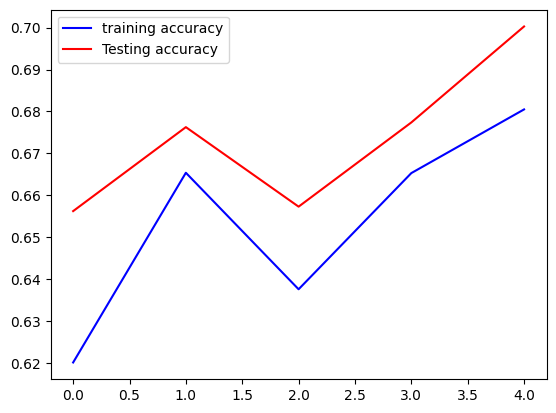

In [ ]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

## Visualizing Loss During Training

---

### **Purpose**:
This code visualizes the loss of the U-Net model on the training and testing datasets during training. The loss curve helps assess how well the model minimizes the error over time.

---

### **Why This Step is Important**:
1. **Tracks Model Training**:
   - Observes how the model minimizes its error (loss) over epochs.
   - A steady decline in loss indicates successful optimization.

2. **Detects Overfitting or Underfitting**:
   - **Overfitting**: Training loss decreases, but validation loss stagnates or increases, suggesting poor generalization to unseen data.
   - **Underfitting**: Both training and validation losses remain high, indicating the model struggles to learn from the data.

3. **Validation of Early Stopping**:
   - Confirms whether early stopping was triggered at the right point (e.g., when validation loss plateaued or worsened).

---

### **Outcome**:
After running this code:
1. A line graph is displayed, showing the training and testing loss for each epoch.
2. The graph helps evaluate the model’s learning behavior and the effectiveness of early stopping.

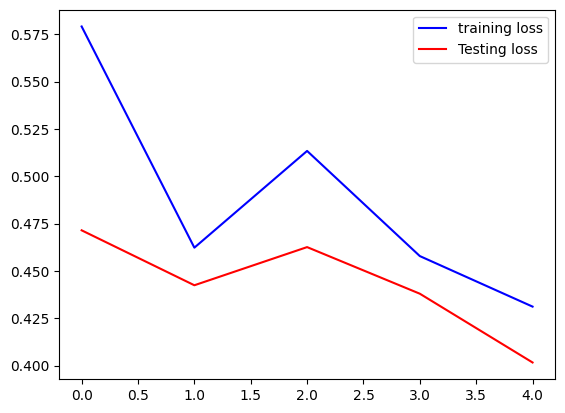

In [ ]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

## Visualizing Predictions

---

### **Purpose**:
This function visually compares the original satellite images, their corresponding ground truth masks, and the predicted masks generated by the trained U-Net model. It helps evaluate the model's segmentation performance qualitatively.

---

### **Explanation**:

1. **Function Definition**:
   - **`image_files`**: List of file paths for satellite images.
   - **`mask_files`**: List of file paths for ground truth masks.
   - **`model`**: Trained U-Net model used for prediction.
   - **`num_examples`**: Number of examples to visualize (default is 5).
   - **`img_size`**: Dimensions to resize the input and output masks (default is `(128, 128)`).

---

### **Why This Step is Important**:
1. **Qualitative Evaluation**:
   - Helps visually assess how well the model predicts segmentation masks compared to the ground truth.
2. **Debugging**:
   - Identifies potential issues such as misaligned predictions, incomplete masks, or over/under-segmentation.
3. **Model Improvement**:
   - Insights from these visualizations can guide further model fine-tuning or adjustments.

---

### **Outcome**:
After running this function:
1. Side-by-side comparisons of images, ground truth masks, and predictions are displayed.
2. These visualizations provide a qualitative understanding of the model’s segmentation performance.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


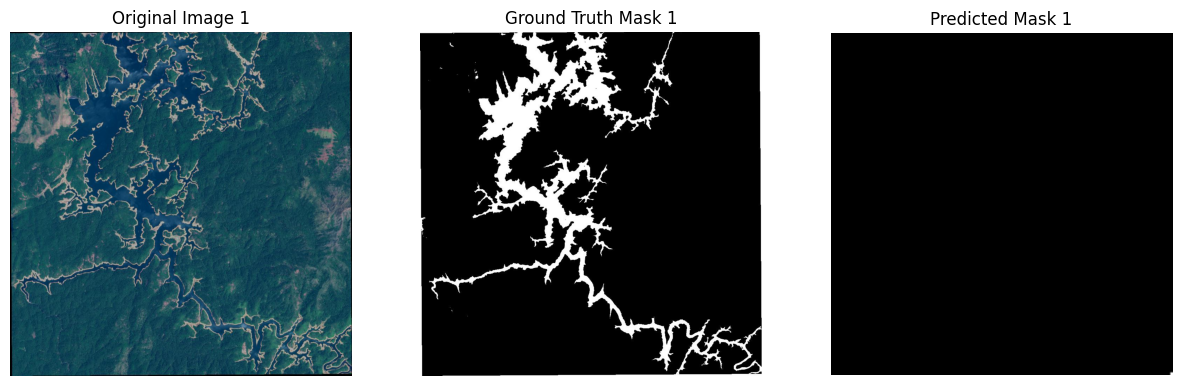

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


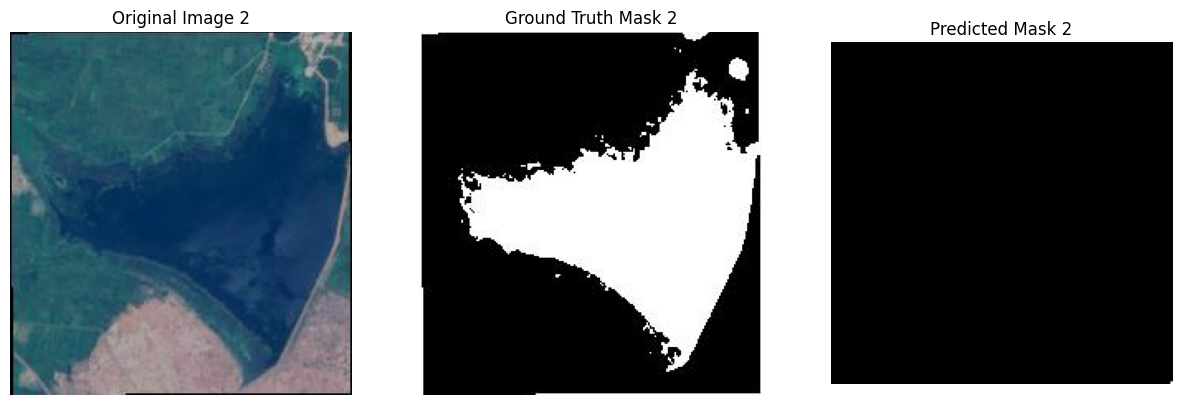

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


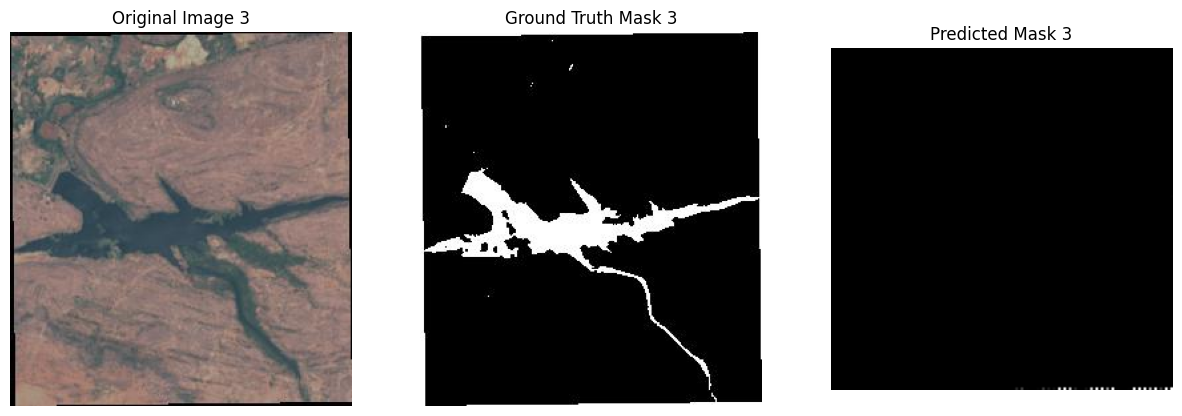

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def visualize_predictions(image_files, mask_files, model, num_examples=5, img_size=(128, 128)):
    """
    Visualizes randomly selected satellite images, ground truth masks, and predicted masks.

    Args:
        image_files (list): List of file paths to satellite images.
        mask_files (list): List of file paths to corresponding masks.
        model: Trained model for predicting masks.
        num_examples (int): Number of examples to display.
        img_size (tuple): Dimensions of predicted masks (height, width).
    """
    num_examples = min(num_examples, len(image_files), len(mask_files))

    # Randomly select indices
    random_indices = random.sample(range(len(image_files)), num_examples)

    for i, idx in enumerate(random_indices):
        # Load the original image and mask
        image = Image.open(image_files[idx])
        mask = Image.open(mask_files[idx])

        # Preprocess image for prediction
        input_img = np.array(image)  # Convert image to NumPy array

        # Resize the image to match the model's input shape
        input_img = cv2.resize(input_img, img_size)  # Resize using OpenCV

        input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension

        # Predict the mask
        predicted_mask = model.predict(input_img).reshape(img_size)

        # Plot image, ground truth mask, and predicted mask
        plt.figure(figsize=(15, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.title(f"Original Image {i+1}")
        plt.imshow(image)
        plt.axis("off")

        # Display ground truth mask
        plt.subplot(1, 3, 2)
        plt.title(f"Ground Truth Mask {i+1}")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Mask {i+1}")
        plt.imshow(predicted_mask, cmap="gray")
        plt.axis("off")

        plt.show()

# Example usage
visualize_predictions(image_files, mask_files, model, num_examples=3, img_size=(128, 128))


## Evaluating the Model Using IoU (Intersection over Union)

---

### **Purpose**:
This step calculates the **Intersection over Union (IoU)**, also known as the **Jaccard Index**, to evaluate the segmentation model's performance. IoU measures the overlap between the predicted and ground truth masks, providing a robust metric for semantic segmentation tasks.

---

### **Why This Step is Important**:
1. **Robust Evaluation**:
   - IoU is a widely used metric for segmentation tasks, providing a clear measure of overlap between predicted and true masks.

2. **Identifies Model Strength**:
   - High IoU indicates accurate segmentation, while low IoU suggests room for improvement in model architecture or training.

3. **Threshold and Flattening**:
   - Ensures compatibility between predicted and ground truth masks for a fair comparison.

---

### **Outcome**:
After running this code:
1. The IoU score for the testing dataset is calculated and printed.
2. This score quantitatively evaluates the model's segmentation accuracy.

In [ ]:
from sklearn.metrics import jaccard_score

# Assuming y_test has continuous values (e.g., grayscale),
# threshold it to binary as well
y_test_binary = (y_test > 0.5).astype(int)

# Flatten masks for IoU calculation
iou = jaccard_score(y_test_binary.flatten(), (model.predict(X_test) > 0.5).astype(int).flatten())
print("IoU Score:", iou)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
IoU Score: 0.4580217295238571
